2025-09-25 19:48:02.959221: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-25 19:48:03.064830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 19:48:06.654231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 19:48:21.904684: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Loading trained LSTM model …


2025-09-25 19:48:27.561635: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✓ Model loaded.
Found saved scalers. Loading …
Phase-1 PD subjects: 48
Target BW distribution for simulation: Uniform[70.0, 140.0] kg
Running QD and QW Monte-Carlo …


QD MC:   0%|          | 0/200 [00:00<?, ?it/s]

2025-09-25 19:48:28.983611: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


QD MC:   0%|          | 0/200 [00:00<?, ?it/s]

QW MC:   0%|          | 0/200 [00:00<?, ?it/s]

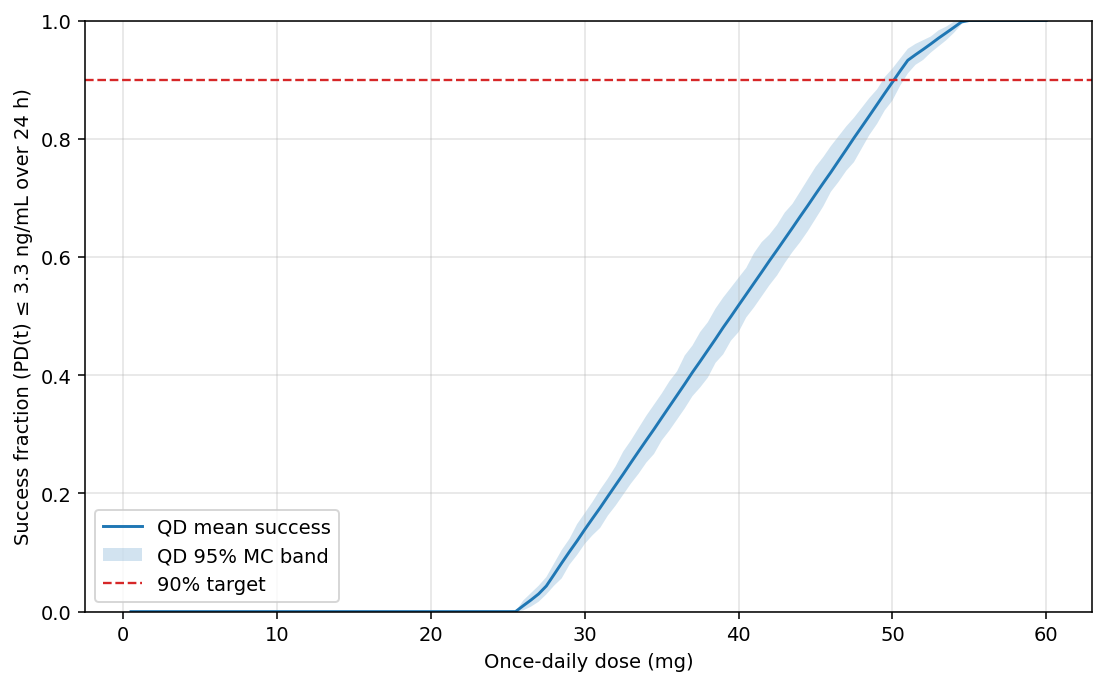

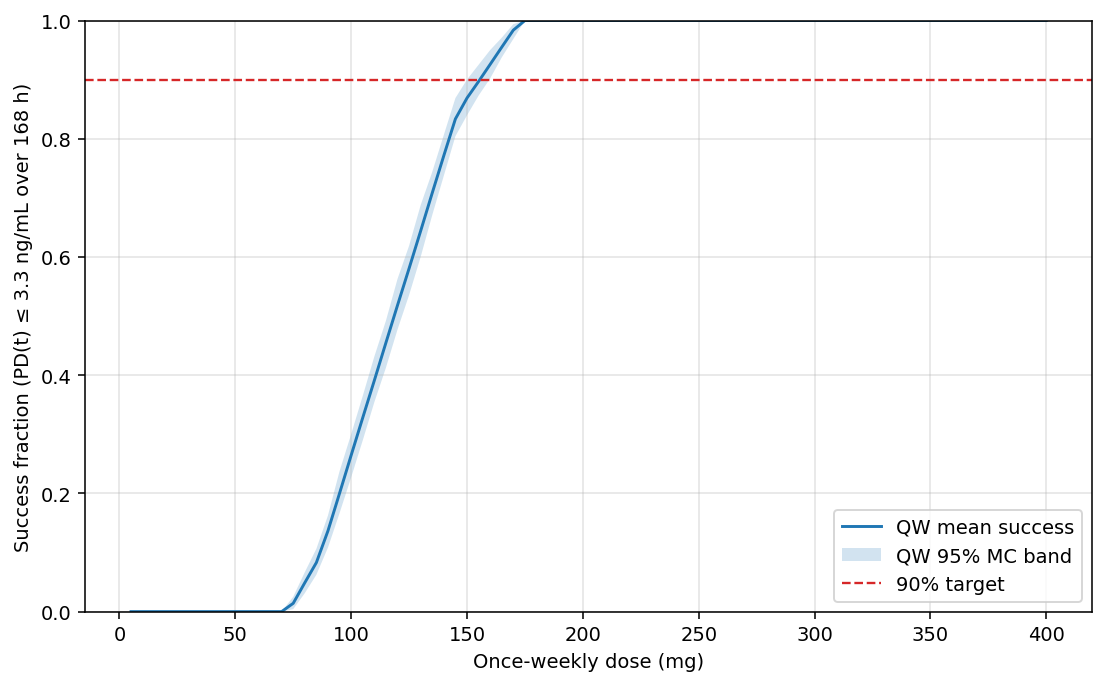


=== Results for BW ~ Uniform(70, 140) kg ===
QD minimal dose for ≥90% success (MC mean): 50.3 mg  | 95% CI: [49.5, 51.0] mg
QD minimal dose (on mean curve):            50.5 mg
QW minimal dose for ≥90% success (MC mean): 158 mg  | 95% CI: [150.0, 160.0] mg
QW minimal dose (on mean curve):            160 mg

Debug:
  QD grid top = 60.0 mg; QD max success at grid top = 1.000

Saved:
  qd_70_140kg_dose_success.png
  qw_70_140kg_dose_success.png
  qd_70_140kg_dose_success_summary.csv
  qw_70_140kg_dose_success_summary.csv


In [1]:
# -*- coding: utf-8 -*-
"""
Effect of changing body weight distribution to 70–140 kg on optimal QD/QW doses
--------------------------------------------------------------------------------
- Loads trained LSTM PD(t) model (no retraining)
- Rebuilds/loads time & PD scalers from Phase-1 data
- Monte Carlo with BW ~ Uniform(70, 140) kg, COMED ~ Bernoulli(p_phase1)
- QD grid: auto-extends (0.5 mg steps) until it crosses 90% success
- QW grid: 5 mg steps (fixed)
- Success = max_t PD(t) ≤ 3.3 ng/mL over full interval at steady-state
- Outputs: minimal dose achieving ≥90% success (mean & 95% CI) for QD & QW
"""

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140

from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow.keras import models

# ----------------------------- Config -----------------------------
MODEL_PATH        = "lstm_best.h5"   # your trained LSTM saved model
STRICT_THRESHOLD  = 3.3              # ng/mL success threshold
TAU_QD            = 24.0             # 24 h (once-daily)
TAU_QW            = 168.0            # 168 h (once-weekly)

# Dose grids
QD_MAX_DOSE       = 40.0             # mg (initial ceiling; grid will auto-extend if needed)
QD_STEP           = 0.5              # mg
QW_MAX_DOSE       = 400.0            # mg
QW_STEP           = 5.0              # mg

# Monte Carlo settings
K_EXPAND          = 10               # pop expansion relative to Phase-1 N
R_MC              = 200              # MC replicates (increase for tighter CIs)
BW_RANGE          = (70.0, 140.0)    # target population BW range
TIME_SCALER_PATH  = "time_scaler_qd.pkl"
Y_SCALER_PATH     = "y_scaler_pd.pkl"
SEED              = 42

rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------- Utilities: IO for scalers ----------------
def save_scaler(scaler: StandardScaler, path: str):
    import joblib
    joblib.dump(scaler, path)

def load_scaler(path: str) -> StandardScaler:
    import joblib
    return joblib.load(path)

# ------------------------- Robust model load ----------------------
def load_trained_model(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Missing '{path}'. Train your LSTM first (produces an .h5 or SavedModel dir)."
        )
    try:
        # Fix Keras v3 'mse' issue for legacy H5
        return models.load_model(
            path,
            custom_objects={"mse": tf.keras.losses.MeanSquaredError()},
            compile=False,
        )
    except TypeError:
        # Fallback if environment differs
        return models.load_model(path, compile=False)

print("Loading trained LSTM model …")
model = load_trained_model(MODEL_PATH)
print("✓ Model loaded.")

# ------------------- Prepare / rebuild scalers --------------------
def load_or_build_scalers():
    have_both = os.path.exists(TIME_SCALER_PATH) and os.path.exists(Y_SCALER_PATH)
    if have_both:
        print("Found saved scalers. Loading …")
        return load_scaler(TIME_SCALER_PATH), load_scaler(Y_SCALER_PATH)

    print("Preparing scalers from Phase-1 data …")
    df = pd.read_csv("EstData.csv")
    for c in ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","DVID","AMT"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["ID","TIME","EVID","MDV","DVID"])
    df = df[df["TIME"] >= 0].sort_values(["ID","TIME"])

    obs = df[(df["EVID"]==0) & (df["MDV"]==0)]
    pd_df = obs[obs["DVID"]==2].copy()

    def infer_tau(s):
        d = s[s["EVID"]==1]
        if len(d):
            t = np.sort(d["TIME"].dropna().unique())
            return float(np.median(np.diff(t))) if len(t)>=2 else TAU_QD
        return TAU_QD

    def last_window(s, tau, min_points=3, max_expand=8.0):
        if s.empty: return s.iloc[0:0].copy()
        tmax = float(s["TIME"].max()); best, bestn = s.iloc[0:0].copy(), 0; f=1.0
        while f <= max_expand:
            w = s[(s["TIME"]>=tmax - tau*f) & (s["TIME"]<=tmax)]
            if len(w)>bestn: best, bestn = w.copy(), len(w)
            if len(w) >= min_points: return w.sort_values("TIME")
            f *= 1.5
        return best.sort_values("TIME")

    def resample_to_grid(time, value, grid):
        if len(time)==0: return np.full_like(grid, np.nan, float)
        ix = np.argsort(time)
        t, v = np.asarray(time)[ix], np.asarray(value)[ix]
        out = np.interp(grid, t - t.min(), v, left=np.nan, right=np.nan)
        # repair NaNs (forward-fill then linear)
        if np.isnan(out[0]):
            first = np.nanmin(np.where(~np.isnan(out))[0])
            out[:first] = out[first]
        m = np.isnan(out)
        if m.any():
            out[m] = np.interp(np.where(m)[0], np.where(~m)[0], out[~m])
        return out

    # Build 24-point PD sequences to fit scalers
    T = 24
    grid_24h = np.linspace(0, TAU_QD, T)
    y_all, t_all = [], []
    for sid, s in pd_df.groupby("ID"):
        tau = infer_tau(df[df["ID"]==sid])
        w = last_window(s.sort_values("TIME"), tau, 3, 8.0)
        if w.empty: continue
        vg = resample_to_grid(w["TIME"].values.astype(float),
                              w["DV"].values.astype(float), grid_24h)
        y_all.append(vg)
        t_all.append(grid_24h / TAU_QD)

    if not y_all:
        raise RuntimeError("Could not build PD sequences to fit scalers from EstData.csv.")

    y_all = np.asarray(y_all, float)  # (N,24)
    t_all = np.asarray(t_all, float)  # (N,24)

    y_scaler = StandardScaler().fit(y_all.reshape(-1,1))
    time_scaler = StandardScaler().fit(t_all.reshape(-1,1))

    save_scaler(time_scaler, TIME_SCALER_PATH)
    save_scaler(y_scaler, Y_SCALER_PATH)
    print("✓ Scalers fitted & saved.")
    return time_scaler, y_scaler

time_scaler, y_scaler = load_or_build_scalers()

# ---------------------- Phase-1 COMED probability ----------------
df_phase1 = pd.read_csv("EstData.csv")
for c in ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","DVID","AMT"]:
    if c in df_phase1.columns: df_phase1[c] = pd.to_numeric(df_phase1[c], errors="coerce")

ids = df_phase1["ID"].dropna().unique()
COM_obs = []
for sid in ids:
    s = df_phase1[df_phase1["ID"]==sid]
    if s["COMED"].notna().any():
        COM_obs.append(int(s["COMED"].dropna().iloc[0]))
COM_obs = np.array([c for c in COM_obs if c in [0,1]])
p_comed = 0.5 if COM_obs.size == 0 else float(np.mean(COM_obs))

# ---------------------- Simulators (QD & QW) ---------------------
def make_batch(TAU, Tpoints, BW, COMED, dose_mg, tau_norm):
    """
    Features: [time_norm, dose_mgkg, comed, tau_norm]
    """
    N = len(BW)
    tgrid = np.linspace(0, TAU, Tpoints)
    dose_mgkg = dose_mg / np.clip(BW, 1e-6, None)
    Xb = np.stack([
        (tgrid/TAU) * np.ones((N, Tpoints)),      # time_norm
        np.tile(dose_mgkg[:, None], (1, Tpoints)),# mg/kg
        np.tile(COMED[:, None], (1, Tpoints)),    # 0/1
        np.full((N, Tpoints), tau_norm, float)    # tau_norm
    ], axis=-1).astype(float)
    # scale time channel with training scaler
    Xb[..., 0] = time_scaler.transform(Xb[..., 0].reshape(-1,1)).reshape(N, Tpoints)
    return Xb, tgrid

def predict_qd_pd_ngml(BW, COMED, dose_mg, Tpoints=24):
    Xb, tgrid = make_batch(TAU_QD, Tpoints, BW, COMED, dose_mg, tau_norm=1.0)
    yhat_z = model.predict(Xb, verbose=0).squeeze(-1)                     # (N,Tpoints)
    yhat   = y_scaler.inverse_transform(yhat_z.reshape(-1,1)).reshape(yhat_z.shape)
    return yhat, tgrid  # ng/mL

def predict_qw_pd_ngml(BW, COMED, dose_weekly_mg, Tpoints=168):
    Xb, tgrid = make_batch(TAU_QW, Tpoints, BW, COMED, dose_weekly_mg, tau_norm=TAU_QW/TAU_QD)
    yhat_z = model.predict(Xb, verbose=0).squeeze(-1)                     # (N,Tpoints)
    yhat   = y_scaler.inverse_transform(yhat_z.reshape(-1,1)).reshape(yhat_z.shape)
    return yhat, tgrid  # ng/mL

# ------------------------- MC helpers -----------------------------
def mc_success_curve_qd(dose_grid, N_base, R=R_MC):
    succ_mat = np.zeros((R, len(dose_grid)))
    dose90   = np.full(R, np.nan)
    for r in tqdm(range(R), desc="QD MC"):
        # Draw new pop with BW ~ Uniform(70, 140)
        BW = rng.uniform(BW_RANGE[0], BW_RANGE[1], size=N_base*K_EXPAND)
        COM = rng.binomial(1, p_comed, size=N_base*K_EXPAND)
        s = []
        for d in dose_grid:
            yhat, _ = predict_qd_pd_ngml(BW, COM, d, Tpoints=24)
            ok = (np.nanmax(yhat, axis=1) <= STRICT_THRESHOLD)  # PD ≤ thresh for all 24 h
            s.append(ok.mean())
        s = np.array(s)
        succ_mat[r,:] = s
        i90 = np.where(s >= 0.90)[0]
        if i90.size:
            dose90[r] = float(dose_grid[i90[0]])
    return succ_mat, dose90

def mc_success_curve_qw(dose_grid, N_base, R=R_MC):
    succ_mat = np.zeros((R, len(dose_grid)))
    dose90   = np.full(R, np.nan)
    for r in tqdm(range(R), desc="QW MC"):
        BW = rng.uniform(BW_RANGE[0], BW_RANGE[1], size=N_base*K_EXPAND)
        COM = rng.binomial(1, p_comed, size=N_base*K_EXPAND)
        s = []
        for d in dose_grid:
            yhat, _ = predict_qw_pd_ngml(BW, COM, d, Tpoints=168)
            ok = (np.nanmax(yhat, axis=1) <= STRICT_THRESHOLD)  # PD ≤ thresh for all 168 h
            s.append(ok.mean())
        s = np.array(s)
        succ_mat[r,:] = s
        i90 = np.where(s >= 0.90)[0]
        if i90.size:
            dose90[r] = float(dose_grid[i90[0]])
    return succ_mat, dose90

def summarize_curve(succ_mat, dose_grid, dose90_samples):
    succ_mean = succ_mat.mean(axis=0)
    succ_lo   = np.percentile(succ_mat, 2.5, axis=0)
    succ_hi   = np.percentile(succ_mat, 97.5, axis=0)
    if np.isfinite(dose90_samples).any():
        d90_mean = float(np.nanmean(dose90_samples))
        d90_ci   = (float(np.nanpercentile(dose90_samples, 2.5)),
                    float(np.nanpercentile(dose90_samples, 97.5)))
    else:
        d90_mean, d90_ci = np.nan, (np.nan, np.nan)
    # helper to find minimal dose on the mean curve (rounded grid)
    idx = np.where(succ_mean >= 0.90)[0]
    d90_mean_curve = float(dose_grid[idx[0]]) if idx.size else np.nan
    return succ_mean, succ_lo, succ_hi, d90_mean, d90_ci, d90_mean_curve

# ----------------- QD auto-extend helper (NEW) --------------------
def run_qd_until_cross(N_base,
                       start=0.5,
                       step=0.5,
                       initial_max=40.0,
                       extend_by=20.0,
                       max_extends=10,
                       hard_cap=240.0):
    """
    Builds the QD dose grid and runs MC, extending the grid until the mean
    success curve crosses 0.90 or we hit 'hard_cap'.
    """
    grid = np.arange(start, initial_max + step, step)
    succ_qd, d90_qd = mc_success_curve_qd(grid, N_base, R=R_MC)
    succ_mean = succ_qd.mean(axis=0)
    if float(np.nanmax(succ_mean)) >= 0.90:
        return grid, succ_qd, d90_qd

    extends = 0
    while extends < max_extends and grid[-1] < hard_cap:
        last = grid[-1]
        new_top = min(last + extend_by, hard_cap)
        grid = np.arange(step, new_top + step, step)
        succ_qd, d90_qd = mc_success_curve_qd(grid, N_base, R=R_MC)
        succ_mean = succ_qd.mean(axis=0)
        if float(np.nanmax(succ_mean)) >= 0.90:
            return grid, succ_qd, d90_qd
        extends += 1

    # Return best effort (may still be < 0.90 if truly unreachable)
    return grid, succ_qd, d90_qd

# -------------------- Build dose grids & run MC -------------------
qd_initial_max = QD_MAX_DOSE  # keep your config value as the starting ceiling
qw_grid = np.arange(QW_STEP, QW_MAX_DOSE+QW_STEP, QW_STEP)

# Base N from Phase-1 (number of subjects with any PD record)
obs = df_phase1[(df_phase1["EVID"]==0) & (df_phase1["MDV"]==0)]
N_base = int(obs[obs["DVID"]==2]["ID"].nunique())
if N_base < 1:
    N_base = 48  # fallback if dataset is odd

print(f"Phase-1 PD subjects: {N_base}")
print(f"Target BW distribution for simulation: Uniform[{BW_RANGE[0]}, {BW_RANGE[1]}] kg")
print("Running QD and QW Monte-Carlo …")

# --- QD: auto-extend until crossing (NEW) ---
qd_grid, succ_qd, d90_qd = run_qd_until_cross(
    N_base,
    start=QD_STEP,
    step=QD_STEP,
    initial_max=qd_initial_max,
    extend_by=20.0,
    max_extends=10,
    hard_cap=240.0
)

# --- QW: run normally ---
succ_qw, d90_qw = mc_success_curve_qw(qw_grid, N_base, R=R_MC)

qd_mean, qd_lo, qd_hi, qd_d90, qd_d90_ci, qd_d90_curve = summarize_curve(succ_qd, qd_grid, d90_qd)
qw_mean, qw_lo, qw_hi, qw_d90, qw_d90_ci, qw_d90_curve = summarize_curve(succ_qw, qw_grid, d90_qw)

# -------------------------- Plots & CSV ---------------------------
plt.figure(figsize=(8,5))
plt.plot(qd_grid, qd_mean, label="QD mean success")
plt.fill_between(qd_grid, qd_lo, qd_hi, alpha=0.2, label="QD 95% MC band")
plt.axhline(0.90, color="tab:red", ls="--", lw=1.2, label="90% target")
plt.ylim(0,1); plt.xlabel("Once-daily dose (mg)")
plt.ylabel(f"Success fraction (PD(t) ≤ {STRICT_THRESHOLD} ng/mL over 24 h)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig("qd_70_140kg_dose_success.png", dpi=180); plt.show()

plt.figure(figsize=(8,5))
plt.plot(qw_grid, qw_mean, label="QW mean success")
plt.fill_between(qw_grid, qw_lo, qw_hi, alpha=0.2, label="QW 95% MC band")
plt.axhline(0.90, color="tab:red", ls="--", lw=1.2, label="90% target")
plt.ylim(0,1); plt.xlabel("Once-weekly dose (mg)")
plt.ylabel(f"Success fraction (PD(t) ≤ {STRICT_THRESHOLD} ng/mL over 168 h)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig("qw_70_140kg_dose_success.png", dpi=180); plt.show()

pd.DataFrame({
    "qd_dose_mg": qd_grid,
    "succ_mean": qd_mean, "succ_lo2p5": qd_lo, "succ_hi97p5": qd_hi
}).to_csv("qd_70_140kg_dose_success_summary.csv", index=False)

pd.DataFrame({
    "qw_dose_mg": qw_grid,
    "succ_mean": qw_mean, "succ_lo2p5": qw_lo, "succ_hi97p5": qw_hi
}).to_csv("qw_70_140kg_dose_success_summary.csv", index=False)

# --------------------------- Answers ------------------------------
def fmt_ci(ci):
    return f"[{ci[0]:.1f}, {ci[1]:.1f}] mg" if np.isfinite(ci[0]) and np.isfinite(ci[1]) else "N/A"

print("\n=== Results for BW ~ Uniform(70, 140) kg ===")
print(f"QD minimal dose for ≥90% success (MC mean): {qd_d90:.1f} mg  | 95% CI: {fmt_ci(qd_d90_ci)}")
print(f"QD minimal dose (on mean curve):            {qd_d90_curve:.1f} mg")
print(f"QW minimal dose for ≥90% success (MC mean): {qw_d90:.0f} mg  | 95% CI: {fmt_ci(qw_d90_ci)}")
print(f"QW minimal dose (on mean curve):            {qw_d90_curve:.0f} mg")

print("\nDebug:")
print(f"  QD grid top = {qd_grid[-1]:.1f} mg; QD max success at grid top = {float(qd_mean[-1]):.3f}")

print("\nSaved:")
print("  qd_70_140kg_dose_success.png")
print("  qw_70_140kg_dose_success.png")
print("  qd_70_140kg_dose_success_summary.csv")
print("  qw_70_140kg_dose_success_summary.csv")
